In [1]:
import numpy as np
import math
from scipy.stats import unitary_group
from skimage.measure import block_reduce
from opt_einsum import contract
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
import torch
import time
import sys
import matplotlib.pyplot as plt
from matplotlib import rc
from src.QDDPM_torch import DiffusionModel, QDDPM, naturalDistance
import src.ImageEncode as ie
rc('text', usetex=False)
rc('axes', linewidth=3)

Please first ``pip install -U qiskit`` to enable related functionality in translation module


In [2]:
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)} is available.")
else:
    print("No GPU available. Torch will use CPU.")

No GPU available. Torch will use CPU.


In [2]:
def image_encode(image_values: np.array, npixels: int):
    '''
    Args:
        image_values: 2-dimensional array (non hairy) of image data
    '''
    norm: float = np.linalg.norm(image_values)
    normalized_image_values: np.array = image_values.flatten()/norm
    return normalized_image_values
    

In [25]:
pixelValues = []
for i in range(4):
    value = 0.33 * i
    pixelValues.append(value)
    print(value)


0.0
0.33
0.66
0.99


[[0.   0.33]
 [0.66 0.99]]


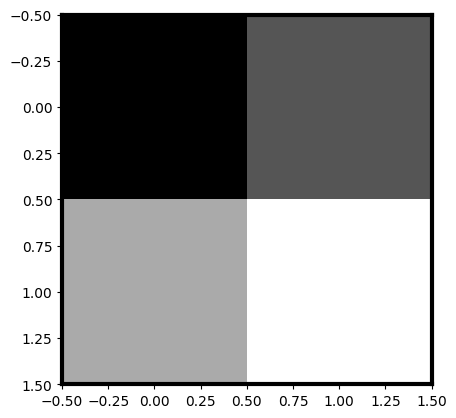

[0.         0.40824829 0.57735027 0.70710678]


In [35]:
values = np.array([pixelValues[0:2], pixelValues[2:4]])
print(values)
normalized = ie.normalize(values**0.5)
plt.imshow(values, cmap='grey', interpolation='nearest')
plt.show()
print(normalized)

In [30]:
def generate_training(values: np.array, n_train: int, scale: float, seed=None):
    np.random.seed(seed)
    n = values.size
    noise = abs(np.random.randn(n_train,n))+0j*np.random.randn(n_train,n) 
    print(noise.shape)
    print(values.shape)
    states = (noise*scale) + values
    states/=np.tile(np.linalg.norm(states, axis=1).reshape(1,n_train), (n,1)).T
    return states
    

In [36]:
a = generate_training(normalized, 400, 2)
print(a)

print(a[0][0]**2 + a[0][1]**2 + a[0][2]**2 + a[0][3]**2)

(400, 4)
(4,)
[[0.12300937+0.j 0.69895506+0.j 0.32653932+0.j 0.62426163+0.j]
 [0.00760513+0.j 0.8901674 +0.j 0.43856721+0.j 0.12330026+0.j]
 [0.36228654+0.j 0.31095838+0.j 0.64164074+0.j 0.60029202+0.j]
 ...
 [0.17635503+0.j 0.71914823+0.j 0.2287157 +0.j 0.63199197+0.j]
 [0.61743192+0.j 0.66997752+0.j 0.32663086+0.j 0.25143633+0.j]
 [0.05246876+0.j 0.41420422+0.j 0.30707166+0.j 0.85521278+0.j]]
(1+0j)


In [75]:
#generate diffusion data
n = 2
T = 20
Ndata = 400

diff_hs = np.linspace(0.5, 4., T)

model_diff = DiffusionModel(n, T, Ndata)
X = torch.from_numpy(generate_training(normalized, Ndata, 2))

Xout = np.zeros((T+1, Ndata, 2**n), dtype = np.complex64)
Xout[0] = X
print(X)

for t in range(1, T+1):
    Xout[t] = model_diff.set_diffusionData_t(t, X, diff_hs[:t], seed = t).numpy()
    print(t)

(400, 4)
(4,)
tensor([[0.0828+0.j, 0.6683+0.j, 0.6157+0.j, 0.4091+0.j],
        [0.0495+0.j, 0.8845+0.j, 0.4176+0.j, 0.2023+0.j],
        [0.1252+0.j, 0.3015+0.j, 0.6755+0.j, 0.6612+0.j],
        ...,
        [0.0397+0.j, 0.5716+0.j, 0.6950+0.j, 0.4344+0.j],
        [0.2892+0.j, 0.3504+0.j, 0.5592+0.j, 0.6935+0.j],
        [0.4606+0.j, 0.6026+0.j, 0.2949+0.j, 0.5811+0.j]],
       dtype=torch.complex128)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [76]:
np.save("states_diff", Xout)

In [89]:
states_diff = np.load('states_diff.npy')

fidelity = np.zeros((T + 1, Ndata))
for i in range(0, T + 1):
    for j in range(0, Ndata):
        fidelity[i][j] = np.abs(np.vdot(states_diff[i][j], states_diff[0][j])) ** 2

fidelity_mean = np.mean(fidelity, axis = 1)
print(fidelity_mean)

[0.99999999 0.98253863 0.94753826 0.89095526 0.81348547 0.70168178
 0.61086734 0.49751561 0.38665529 0.32609322 0.28892829 0.2825263
 0.27051659 0.26766173 0.28227112 0.28903531 0.27297506 0.26670017
 0.24835653 0.24392531 0.26457061]


C:\Users\George Zia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\George Zia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


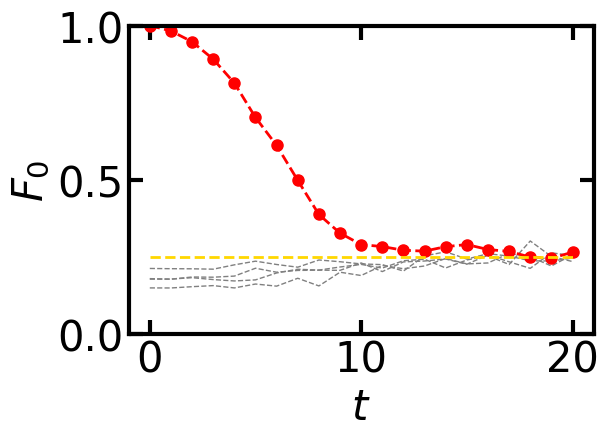

In [91]:
# visualize the fidelity decay in the diffusion process
n = 2
T = 20
Ndata = 400
states_diff = np.load('states_diff.npy')

fig, ax = plt.subplots(figsize=(6, 4))
indices = np.random.permutation(Ndata)
for i in range(10):
    ax.plot(range(T+1), np.mean(np.abs(states_diff[:, indices[100*i:100*(i+1)], 0])**2, axis=1),'--', lw=1, c='grey')
ax.plot(range(T+1), fidelity_mean, 'o--', markersize=8, lw=2, c='r')
ax.plot(range(T+1), 0.25*np.ones(T+1), '--', lw=2, c='gold')
ax.set_ylabel(r'$F_0$', fontsize=30)
ax.set_xlabel(r'$t$', fontsize=30)
ax.set_ylim(0,1)
ax.tick_params(direction='in', length=10, width=3, top='on', right='on', labelsize=30)

In [40]:
def Training_t(model, t, inputs_T, params_tot, Ndata, epochs):
    '''
    the trianing for the backward PQC at step t
    input_tplus1: the output from step t+1, as the role of input at step t
    Args:
    model: the QDDPM model
    t: the diffusion step
    inputs_T: the input data at step t=T
    params_tot: collection of PQC parameters before step t
    Ndata: number of samples in dataset
    epochs: the number of iterations
    '''
    input_tplus1 = model.prepareInput_t(inputs_T, params_tot, t, Ndata) # prepare input
    states_diff = model.states_diff
    loss_hist = [] # record of training history

    # initialize parameters
    np.random.seed()
    params_t = torch.tensor(np.random.normal(size=2 * model.n_tot * model.L), requires_grad=True)
    # set optimizer and learning rate decay
    optimizer = torch.optim.Adam([params_t], lr=0.0005)
    
    t0 = time.time()
    for step in range(epochs):
        indices = np.random.choice(states_diff.shape[1], size=Ndata, replace=False)
        true_data = states_diff[t, indices]

        output_t = model.backwardOutput_t(input_tplus1, params_t)
        loss = naturalDistance(output_t, true_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_hist.append(loss) # record the current loss
        
        if step%100 == 0:
            loss_value = loss_hist[-1]
            print("Step %s, loss: %s, time elapsed: %s seconds"%(step, loss_value, time.time() - t0))

    return params_t, torch.stack(loss_hist)

In [15]:
#train on diffusion data
n, na = 2, 1 # number of data and ancilla qubits
T = 20 # number of diffusion steps
L = 6 # layer of backward PQC
Ndata = 400 # number of data in the training data set
epochs = 2001 # number of training epochs

#gen random samples at t = T
diffModel = DiffusionModel(n, T, Ndata)
inputs_T = diffModel.HaarSampleGeneration(Ndata, seed = 22)

#load diffusion process
states_diff = Xout

model = QDDPM(n=n, na=na, T=T, L=L)
model.set_diffusionSet(states_diff)

params_total = []
loss_hist_total = []

for t in range(T - 1, -1, -1):
    params_tot = np.zeros((T, 2*(n+na)*L))
    for tt in range(t+1, 20):
        print(tt)
        params_tot[tt] = np.load('data/cluster/n2/QDDPMcluster0params_n2na1T20L6_t%d_mmd.npy'%tt)
    
    params, loss_hist = Training_t(model, t, inputs_T, params_tot, Ndata, epochs)

    np.save('data/cluster/n2/QDDPMcluster0params_n2na1T20L6_t%d_mmd.npy'%t, params.detach().numpy())
    np.save('data/cluster/n2/QDDPMcluster0loss_n2na1T20L6_t%d_mmd.npy'%t, loss_hist.detach().numpy())
    
    #params_total = np.append(params_total, params, axis = 1)
    #loss_hist_total = np.append(loss_hist_total, loss_hist, axis = 1)


Step 0, loss: tensor(0.0530, grad_fn=<SubBackward0>), time elapsed: 0.1265239715576172 seconds
Step 100, loss: tensor(0.0279, grad_fn=<SubBackward0>), time elapsed: 8.191352367401123 seconds
Step 200, loss: tensor(0.0176, grad_fn=<SubBackward0>), time elapsed: 14.751994371414185 seconds
Step 300, loss: tensor(0.0081, grad_fn=<SubBackward0>), time elapsed: 21.049241542816162 seconds
Step 400, loss: tensor(0.0044, grad_fn=<SubBackward0>), time elapsed: 27.31992530822754 seconds
Step 500, loss: tensor(0.0032, grad_fn=<SubBackward0>), time elapsed: 33.919762134552 seconds
Step 600, loss: tensor(0.0034, grad_fn=<SubBackward0>), time elapsed: 40.55551314353943 seconds
Step 700, loss: tensor(0.0014, grad_fn=<SubBackward0>), time elapsed: 48.21543622016907 seconds
Step 800, loss: tensor(0.0010, grad_fn=<SubBackward0>), time elapsed: 55.93238592147827 seconds
Step 900, loss: tensor(0.0011, grad_fn=<SubBackward0>), time elapsed: 63.850862979888916 seconds
Step 1000, loss: tensor(0.0016, grad_fn=

In [23]:
n, na = 2, 1
T = 20
L = 6
Ndata = 400
epochs = 2001

params_tot = np.zeros((T, 2*(n+na)*L))
loss_tot = np.zeros((T, epochs))
f0_tot = np.zeros((T, epochs))

for t in range(T):
    params_tot[t] = np.load('data/cluster/n2/QDDPMcluster0params_n2na1T20L6_t%d_mmd.npy'%t)
    loss_tot[t] = np.load('data/cluster/n2/QDDPMcluster0loss_n2na1T20L6_t%d_mmd.npy'%t)
    

np.save("params_total", params_tot)
np.save("loss_tot", loss_tot)                            

[[0.49870968+0.j 0.5       +0.j 0.5       +0.j 0.501287  +0.j]
 [0.49936346+0.j 0.49936346+0.j 0.50063573+0.j 0.50063573+0.j]
 [0.5       +0.j 0.5       +0.j 0.50126743+0.j 0.49872935+0.j]
 ...
 [0.47316022+0.j 0.49282505+0.j 0.51305878+0.j 0.5196283 +0.j]
 [0.49305292+0.j 0.4943837 +0.j 0.50229434+0.j 0.51008232+0.j]
 [0.50156986+0.j 0.50156986+0.j 0.49779388+0.j 0.49905571+0.j]]


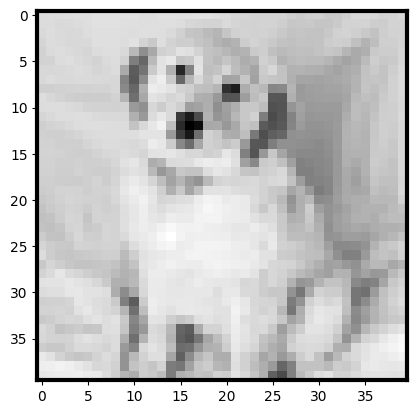

In [73]:
from PIL import Image
scale = 40
img = Image.open('dog.jpg')
img_greyscale = img.convert("L")
img_resized = img_greyscale.resize((scale, scale))

img_array = np.array(img_resized, ndmin = 2)
img_resized.save('dog_resized_greyscale.jpg')

sqrt_array = np.zeros(img_array.size)

for i in range(0, img_array.size):
    sqrt_array[i] = img_array[int(i/40)][i%40] ** 0.5



test_data = np.zeros((int(img_array.size / 4), 4)) + 1j * np.zeros((int(img_array.size / 4), 4))
for i in range(0, int(img_array.size / 4)):
    test_data[i] = ie.normalize(sqrt_array[4*i : 4*i+4]) + 1j * np.zeros(4)


print(test_data)

plt.imshow(img_array, cmap='grey',interpolation = 'nearest')

In [74]:
states_diff = np.load('states_diff.npy')
print(states_diff[:, 0, 0])

[ 0.3154923 +0.j          0.38042396-0.02697232j  0.3280859 -0.05479886j
  0.08592074-0.0270705j   0.16412938-0.18574142j -0.00860999-0.06352714j
  0.21485429+0.02875025j  0.324478  +0.14626355j  0.3607175 -0.3391427j
  0.16455239-0.16609085j  0.46969283-0.38906816j -0.12729536+0.00730539j
 -0.73263997-0.32285228j -0.44488215-0.13316661j -0.33248505+0.20910336j
 -0.42105955-0.2816576j   0.03446135-0.51169896j  0.27525032+0.42371786j
  0.40229082-0.10226546j -0.44536477+0.19954742j -0.0471916 -0.23594981j]


In [25]:
n, na = 2, 1
T = 20
L = 6
Ndata = 400

diffModel = DiffusionModel(n, T, Ndata)

params_tot = np.load('params_total.npy')

model = QDDPM(n=n, na=na, T=T, L=L)

data_te = model.backDataGeneration(test_data, params_tot, Ndata)[:, :, :2**n]

np.save("test_backwardsgen", data_te)

TypeError: can't assign a numpy.ndarray to a torch.ComplexFloatTensor

[[0.   0.33]
 [0.66 0.99]]


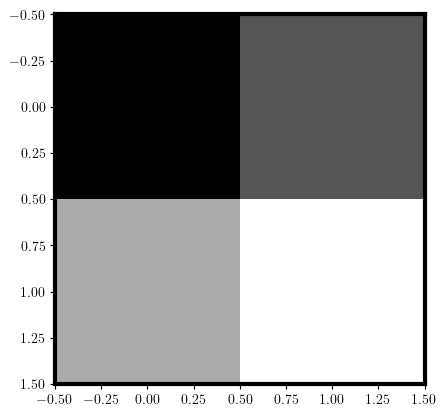

[0.        +0.j 0.26726124+0.j 0.53452248+0.j 0.80178373+0.j]


In [20]:
values = np.array([pixelValues[0:2], pixelValues[2:4]])
print(values)
normalized = ie.normalize(values)
plt.imshow(values, cmap='grey', interpolation='nearest')
plt.show()
normalized = normalized.ravel() + 0j*np.zeros(4)
print(normalized)
